# AI Lab Run
V1: New dataset, old model.   
A3: untrain model.   
A5: this time we change the traning target to predicting the phoneme of each frame (which we can grab from the matched phone guide). From this we again check the several matters concerned and evaluate how well it can be guided to learned the phonemes. 

A6: This time we use CTC as prediction loss. 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchaudio.models.decoder import ctc_decoder

In [2]:
from model_model import VQVAEV1 as TheEncoder
from model_model import VQPhonePredV1 as ThePredictor
from model_dataset import DS_Tools
from model_dataset import WordDatasetPhoneseq as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from paths import *
from misc_my_utils import *
from misc_recorder import *
from model_loss import *
from model_padding import generate_mask_from_lengths_mat

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
BATCH_SIZE = 512

INPUT_DIM = 64
OUTPUT_DIM = 64 

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.3
NUM_LAYERS = 3
EMBEDDING_DIM = 256

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 32
# LOADER_WORKER = 0

## Prepare for this time of training

In [15]:
ts = "0218230825"
stop_epoch = "99"
train_name = "B_04"
this_save_name = f"{train_name}-{ts}-predict"
model_save_dir = os.path.join(model_save_, this_save_name)
encoder_model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(this_save_name)

train_losses = ListRecorder(os.path.join(model_save_dir, "train.loss"))
valid_losses = ListRecorder(os.path.join(model_save_dir, "valid.loss"))
train_accs = ListRecorder(os.path.join(model_save_dir, "train.acc"))
valid_accs = ListRecorder(os.path.join(model_save_dir, "valid.acc"))
text_hist = HistRecorder(os.path.join(model_save_dir, "trainhist.txt"))

B_04-0218230825-predict


In [6]:
READ = True
DATAREAD = True

In [7]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

train_ds = ThisDataset(rec_dir, 
                       train_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "train-phoneseq.gt"))
valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "valid-phoneseq.gt"))

use_proportion = 0.3

if READ or DATAREAD: 
    train_ds_indices = DS_Tools.read_indices(os.path.join(encoder_model_save_dir, "train.use"))
    valid_ds_indices = DS_Tools.read_indices(os.path.join(encoder_model_save_dir, "valid.use"))

    use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
    use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    # valid data
    use_len = int(use_proportion * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
    # the saved train and valid separations will reflect this
    DS_Tools.save_indices(os.path.join(model_save_dir, "train.use"), use_train_ds.indices)
    DS_Tools.save_indices(os.path.join(model_save_dir, "valid.use"), use_valid_ds.indices)

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)

In [8]:
train_num, valid_num, len(train_loader), len(valid_loader)

(231830, 31142, 453, 61)

torch.Size([512, 68, 64])


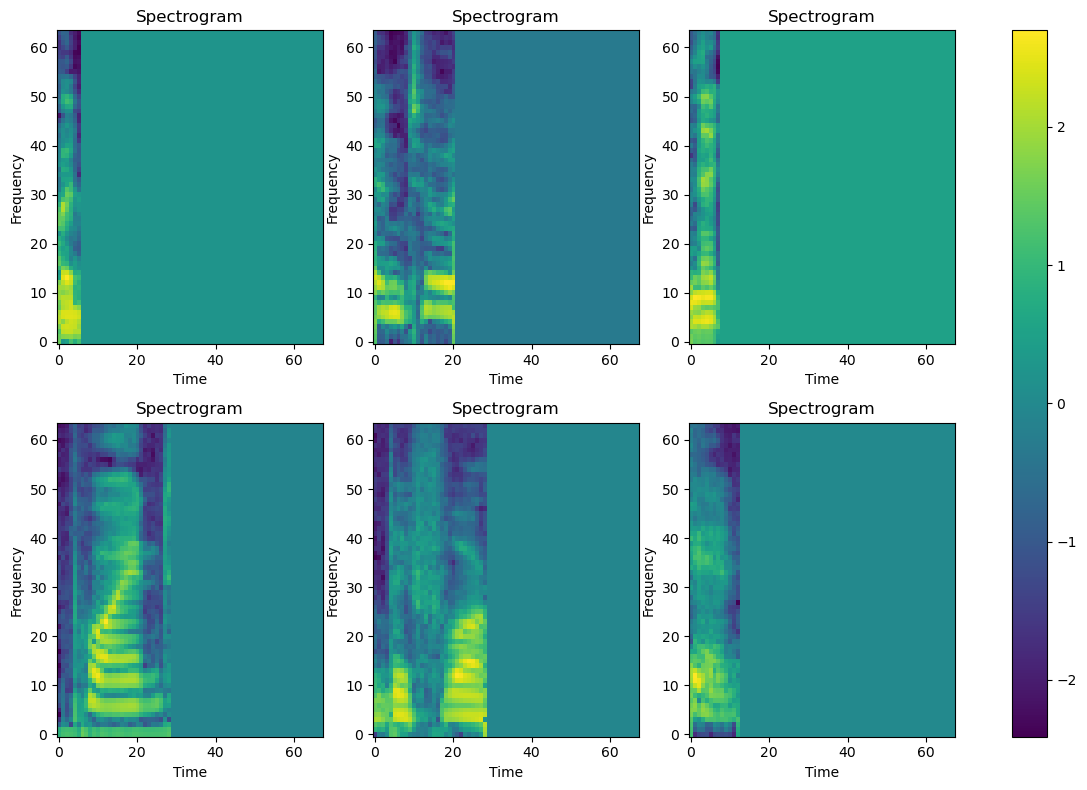

In [10]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
xx_pad, x_lens, yy_pad, y_lens = sample_data
print(xx_pad.shape)
# Set the random seed for reproducibility
# random.seed(101)
# Generate six random indices
# random_indices = random.sample(range(len(xx_pad)), 6)
random_indices = list(range(6, 12))

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = xx_pad[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram.T, aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Prepare model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_loss = nn.CTCLoss(blank=mymap.encode("BLANK"))

encode_model = TheEncoder(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)

predict_model = ThePredictor(in_dim=ENC_SIZE_LIST[3], 
                             out_dim=mymap.token_num())
encode_model.to(device)
predict_model.to(device)

# we only train the predict model
optimizer = optim.Adam(predict_model.parameters(), lr=0.001)

model_str = str(predict_model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, predict_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [13]:
params

360

### Load model if READ

In [16]:
if READ: 
    model_name = "{}.pt".format(stop_epoch)
    model_path = os.path.join(encoder_model_save_dir, model_name)
    state = torch.load(model_path)

    encode_model.load_state_dict(state)
    encode_model.to(device)

    # FREEZE THE ENCODER MODEL
    for param in encode_model.parameters():
        param.requires_grad = False  # Freezing the encoder

In [17]:
EPOCHS = 30
BASE = 0

In [18]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        encode_model.eval()
        predict_model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens, y, y_lens) in enumerate(train_loader):
            # y_lens should be the same as x_lens
            optimizer.zero_grad()
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)
            y = y.long()

            ze, zq = encode_model.encode(x, x_lens, x_mask)
            # print(x_hat, y, x_mask.shape)
            # Here x_hat: (B, L, C); we change to (L, B, C)
            x_hat = predict_model(zq)
            x_hat = x_hat.permute(1, 0, 2)

            # loss = model_loss.get_loss(x_hat, y, x_mask)
            loss = model_loss(x_hat, y, x_lens, y_lens)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "{}.pt".format(epoch)
        torch.save(predict_model.state_dict(), os.path.join(model_save_dir, last_model_name))

        encode_model.eval()
        predict_model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens, y, y_lens) in enumerate(valid_loader):
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)
            y = y.long()

            ze, zq = encode_model.encode(x, x_lens, x_mask)
            x_hat = predict_model(zq)
            x_hat = x_hat.permute(1, 0, 2)
            loss = model_loss(x_hat, y, x_lens, y_lens)
            valid_loss += loss.item()

            if idx % 50 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        # valid_accs.append(valid_correct / valid_total)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [19]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  22.062 in Step 0
Training loss  17.450 in Step 100
Training loss  13.501 in Step 200
Training loss  10.684 in Step 300
Training loss  11.449 in Step 400
※※※Training loss  14.291※※※
Valid loss  8.963 in Step 0
Valid loss  9.257 in Step 50
※※※Valid loss  9.384※※※
Epoch 1
Training loss  9.813 in Step 0
Training loss  9.728 in Step 100
Training loss  9.398 in Step 200
Training loss  8.788 in Step 300
Training loss  8.490 in Step 400
※※※Training loss  9.070※※※
Valid loss  7.364 in Step 0
Valid loss  7.668 in Step 50
※※※Valid loss  7.755※※※
Epoch 2
Training loss  8.621 in Step 0
Training loss  8.140 in Step 100
Training loss  7.672 in Step 200
Training loss  7.344 in Step 300
Training loss  7.472 in Step 400
※※※Training loss  7.909※※※
Valid loss  6.657 in Step 0
Valid loss  7.011 in Step 50
※※※Valid loss  7.016※※※
Epoch 3
Training loss  7.706 in Step 0
Training loss  7.326 in Step 100
Training loss  7.062 in Step 200
Training loss  6.914 in Step 300
Training loss  6.72

In [20]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

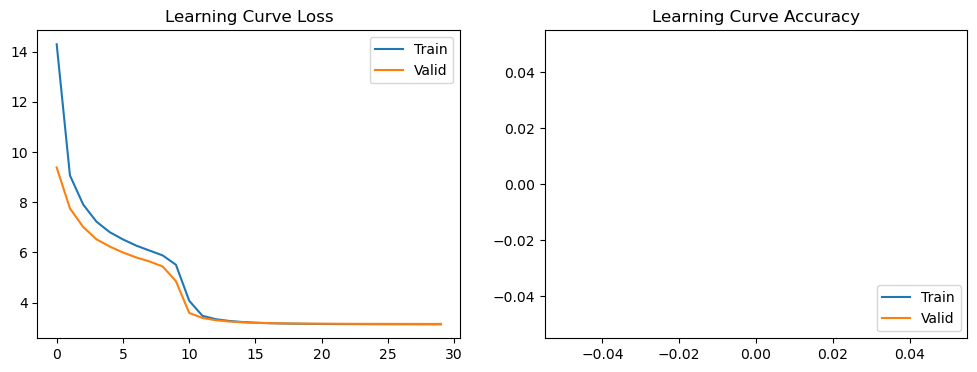

In [23]:
start, end = 0, 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Plot Loss on the left subplot
ax1.plot(train_losses.get()[start:end], label='Train')
ax1.plot(valid_losses.get()[start:end], label='Valid')
ax1.set_title("Learning Curve Loss")
ax1.legend(loc="upper right")

# Plot Accuracy on the right subplot
ax2.plot(train_accs.get()[start:end], label='Train')
ax2.plot(valid_accs.get()[start:end], label='Valid')
ax2.set_title('Learning Curve Accuracy')
ax2.legend(loc="lower right")

## Testing

In [25]:
import torchaudio
from tqdm import tqdm

In [26]:
CTCDecoder = ctc_decoder(
    lexicon=None, 
    tokens=mylist + ["|"], 
    blank_token="BLANK"
)

In [29]:
ALLOWTESTREAD = False

In [30]:
test_ds = ThisDataset(rec_dir, 
                       test_guide_path, 
                       mapper=mymap, 
                       transform=mytrans, 
                       ground_truth_path=os.path.join(src_, "test-phoneseq.gt"))

use_proportion = 0.1

if ALLOWTESTREAD and (READ or DATAREAD): 
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))
    use_test_ds = torch.utils.data.Subset(test_ds,test_ds_indices)
else: 
    # train data
    use_len = int(use_proportion * len(test_ds))
    remain_len = len(test_ds) - use_len
    use_test_ds, remain_ds = random_split(test_ds, [use_len, remain_len])
    DS_Tools.save_indices(os.path.join(model_save_dir, "test.use"), use_train_ds.indices)

test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn_yNoPad)
test_num = len(test_loader.dataset)

In [36]:
encode_model.eval()
predict_model.eval()
test_loss = 0.
test_num = len(test_loader)
preds = []
reals = []
for (x, x_lens, y, y_lens) in tqdm(test_loader):
    x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
    
    x = x.to(device)

    ze, zq = encode_model.encode(x, x_lens, x_mask)
    x_hat = predict_model(zq)
    # x_hat = x_hat.permute(1, 0, 2)

    # print(x_hat)
    # raise Exception

    preds += CTCDecoder(x_hat.cpu())
    reals += y

100%|██████████| 20/20 [02:36<00:00,  7.84s/it]


In [37]:
total_per = 0
total = 0
for real, pred in zip(reals, preds): 
    total_per += torchaudio.functional.edit_distance(real, pred[0].tokens[1:-1]) / len(real)
    total += 1

In [40]:
i = torch.randint(0, total, size=(1, )).item()
print([mymap.decode(x.item()) for x in reals[i]])
print([mymap.decode(x.item()) for x in preds[i][0].tokens[1:-1]])

['N', 'EY', 'M', 'L', 'IY']
[]


In [41]:
total_per / total

1.0